### Loading your API keys using .env

In [218]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [219]:
api_url = os.environ['REDCAP_API_URL']
api_key = os.environ['REDCAP_API_KEY']

### Import the REDCap project data

In [220]:
from redcap import Project # This is actually PyCap, which is annoying.

# Import the REDCap project using your API Key
redcap_project = Project(api_url, api_key)
# Get the data from all the records in the project
redcap_data = redcap_project.export_records()

In [221]:
# Convert the output to a pandas DataFrame
import pandas as pd

df_redcap = pd.DataFrame(redcap_data)
df_redcap.head()

display(df_redcap.head())

# NOTE: You can also just export as a pandas DataFrame directly like this:
# redcap_data = redcap_project.export_records(format='df')

,patient_id,birth_date,diagnosis,sex,handedness,death_date,death_age,visit_date,visit_age,mmse_tot,main_complete
0,23,,2,2,3,,,1998-02-12,,2,0
1,53,1989-04-04,4,2,1,,,1991-10-08,2,9,0
2,70,1969-06-01,5,,3,,,1994-04-05,24,28,0
3,87,1945-11-02,1,2,1,,,2010-10-10,64,11,0
4,97,1974-05-19,4,2,3,,,,,13,0


### Example 1:
- Dr. X wants to know how many patients in the database have a diagnosis of Alzheimer's Disease (AD).
    - Of those cases, how many were under/over 70 years old at testing?

In [222]:
# The variable/column name we are looking for first is "diagnosis" and the value for Alzheimer's Disease is 1
# Now, let's filter the dataframe to only cases with Alzheimer's Disease
df_ad = df_redcap[df_redcap['diagnosis'] == "1"]

# Print the total number of AD cases:
print(f"Total number of AD cases: {len(df_ad)}")

Total number of AD cases: 1756


In [223]:
# Now let's split the group into two groups based on the age cut off of 70 in the variable "visit_age"
age_cutoff = "70"
df_ad_young = df_ad[df_ad['visit_age'] < age_cutoff]
df_ad_old = df_ad[df_ad['visit_age'] >= age_cutoff]

# Print how many cases are in each group
print(f"Number of Alzheimer's Disease cases under {age_cutoff} years old: {len(df_ad_young)}")
print(f"Number of Alzheimer's Disease cases over {age_cutoff} years old: {len(df_ad_old)}")


Number of Alzheimer's Disease cases under 70 years old: 1571
Number of Alzheimer's Disease cases over 70 years old: 185


### Example 2:
- Dr. X now wants to know the amounts of all diagnoses but displayed in a nice, labeled pie chart.

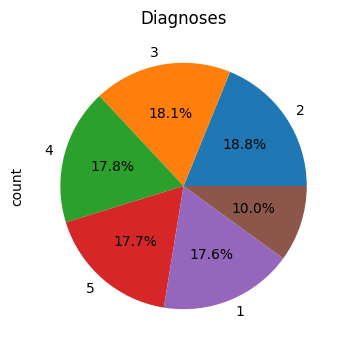

In [224]:
# Let's take the original data and create a pie chart of the distribution of the different diagnoses
import matplotlib.pyplot as plt

# Plot the distribution of the different diagnoses
plt.figure(figsize=(4, 4))
df['diagnosis'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Diagnoses')
plt.show()

In [225]:
# That's nice, but the number values aren't very informative and the NaN values are not labeled.
# Let's try replacing the values with labels using the data dictionary / metadata.

# You can extract the metadata of the project using PyCap like this:
metadata = redcap_project.export_metadata(format_type='df')
# Reset the index of the header rows:
metadata = metadata.groupby('field_name').first().reset_index()
metadata

,field_name,form_name,section_header,field_type,field_label,select_choices_or_calculations,field_note,text_validation_type_or_show_slider_number,text_validation_min,text_validation_max,identifier,branching_logic,required_field,custom_alignment,question_number,matrix_group_name,matrix_ranking,field_annotation
0,birth_date,main,NaN,text,DOB:,None,NaN,date_mdy,NaN,NaN,y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,death_age,main,NaN,calc,Age at Death,"rounddown(datediff([birth_date], [death_date],...",NaN,None,NaN,NaN,y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,death_date,main,NaN,text,Date of Death,None,NaN,date_mdy,NaN,NaN,y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,diagnosis,main,NaN,dropdown,Diagnosis:,"1, Alzheimer's Disease | 2, Frontotemporal Dem...",NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,handedness,main,NaN,dropdown,Handedness,"1, Right | 2, Left | 3, Ambidextrous",NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,mmse_tot,main,NaN,text,MMSE Total Score,None,NaN,integer,0.0,30.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,patient_id,main,NaN,text,Patient ID Number,None,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,sex,main,NaN,dropdown,Sex,"1, Male | 2, Female",NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,visit_age,main,NaN,calc,Age at Visit,"rounddown(datediff([birth_date], [visit_date],...",NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,visit_date,main,NaN,text,Date of Visit,None,NaN,date_mdy,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
# First, let's extract the choices for the "diagnosis" variable from the metadata df 
# by finding the 'field_name' key with the value 'diagnosis' and then returning the 'select_choices_or_calculations' key:
# Return the value for the 'select_choices_or_calculations' key
diagnosis_choices = metadata[metadata['field_name'] == 'diagnosis']['select_choices_or_calculations'].values[0]
# Make the choices into a dict:
diagnosis_choices_dict = dict(item.split(", ") for item in diagnosis_choices.split(" | "))
diagnosis_choices_dict


{'1': "Alzheimer's Disease",
 '2': 'Frontotemporal Dementia',
 '3': 'Primary Progressive Aphasia',
 '4': 'Mild Cognitive Impairment',
 '5': 'Control'}

In [227]:
# Great! Now that we have the relabel dict, we can use it to replace the values in the 'diagnosis' column
# with the actual labels in the plot. But! We still haven't handled the blank/NaN values.
# Let's add to the relable dict a key for the blank/NaN values and call them "Unknown"
diagnosis_choices_dict[''] = 'Unknown'
diagnosis_choices_dict

{'1': "Alzheimer's Disease",
 '2': 'Frontotemporal Dementia',
 '3': 'Primary Progressive Aphasia',
 '4': 'Mild Cognitive Impairment',
 '5': 'Control',
 '': 'Unknown'}

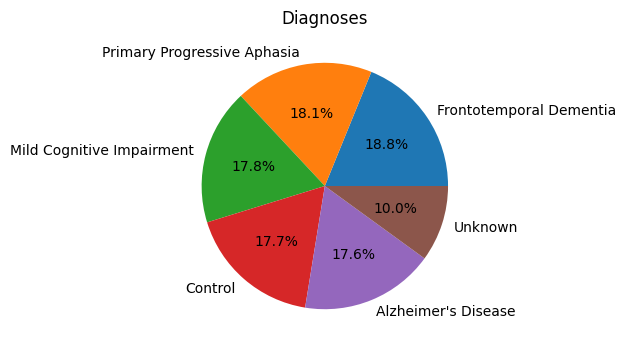

In [228]:
# Now, let's plot the distribution of the diagnoses again but relabeled:
plt.figure(figsize=(4, 4))
df['diagnosis'].replace(diagnosis_choices_dict).value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('') # Remove the "count" label
plt.title('Diagnoses')
plt.show()

### Example 3:
- Dr. X now wants this kind of pie chart for every other categorical variable too (e.g. Sex, Handedness, etc.)

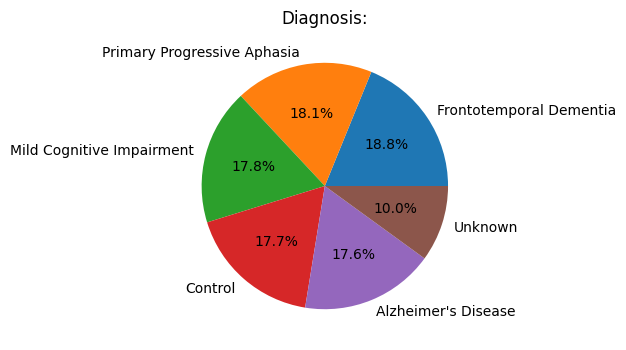

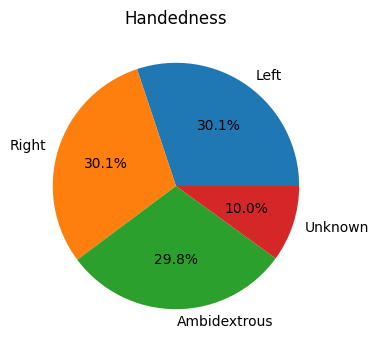

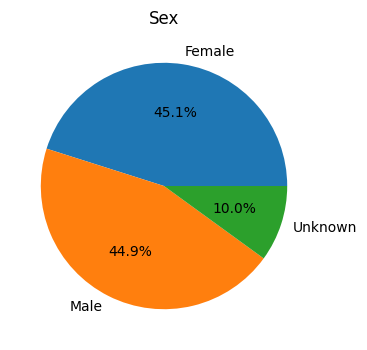

In [229]:
# Rather than doing this all manually every time, let's semi-automate this
# by creating a function to make pie charts for all categorical variables in the data.

def categorical_pie(df, metadata):
    # Find every categorical variable in the metadata (e.g. 'radio', 'dropdown')
    categorical_vars = metadata[metadata['field_type'].str.contains('dropdown|radio', case=False)]
    # Get the field_name, field_label, and selected choices for each categorical variable
    for index, row in categorical_vars.iterrows():
        field_name = row['field_name']
        field_label = row['field_label']
        choices = dict(item.split(", ") for item in row['select_choices_or_calculations'].split(" | "))
        # Add the "Unknown" label for blank/NaN values:
        choices[''] = 'Unknown'
        # Plot the pie chart
        plt.figure(figsize=(4, 4))
        df[field_name].replace(choices).value_counts().plot.pie(autopct='%1.1f%%')
        plt.ylabel('')
        plt.title(field_label)

categorical_pie(df_redcap, metadata)

### More complicated example:
- Dr. X has an important grant submission coming up and needs the following:
    - A table with Sex, Handedness, Age at Visit, and MMSE by Diagnosis
    - Also, plot the MMSE scores by diagnosis.

In [ ]:
# Here is a function that generates a table of demographics for a given group variable
# with categorical and continuous variable lists, replaces the variable names and values with labels,
# adds percentages and counts for categorical variables, and means and standard deviations for continuous variables.

import numpy as np

def create_demographics_table(df, metadata, group_var, categorical_vars, continuous_vars):
    """
    Create a demographics table displaying mean ± SD (n=...) for continuous variables and
    percentages (n=...) for categorical variables, grouped by a specified variable.
    Variable names and codes are replaced with their labels from the metadata.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the dataset.
    metadata (pd.DataFrame): The REDCap metadata DataFrame.
    group_var (str): The name of the grouping variable.
    categorical_vars (list): A list of names of the categorical variables.
    continuous_vars (list): A list of names of the continuous variables.
    
    Returns:
    pd.DataFrame: A formatted demographics table.
    """
    # Create a deep copy of the DataFrame to prevent in-place modifications
    df = df.copy(deep=True)
    
    # Create a mapping from field_name to field_label
    field_label_mapping = dict(zip(metadata['field_name'], metadata['field_label']))
    
    # Replace variable names with their labels
    group_var_label = field_label_mapping.get(group_var, group_var)
    continuous_vars_labels = [field_label_mapping.get(var, var) for var in continuous_vars]
    categorical_vars_labels = [field_label_mapping.get(var, var) for var in categorical_vars]    
    
    # Replace codes with labels in the grouping variable if it's categorical
    group_var_field_type = metadata.loc[metadata['field_name'] == group_var, 'field_type'].values
    if len(group_var_field_type) > 0 and group_var_field_type[0] in ['dropdown', 'radio']:
        choices_str = metadata.loc[metadata['field_name'] == group_var, 'select_choices_or_calculations'].values[0]
        choices_dict = dict(item.strip().split(', ', 1) for item in choices_str.split(' | '))
        # Include "" as a category labeled "Unknown"
        choices_dict[''] = 'Unknown'
        df[group_var] = df[group_var].astype(str).replace({'nan': ''}).map(choices_dict).fillna('Unknown')
    else:
        # For non-dropdown/radio fields, treat NaN as "Unknown"
        df[group_var] = df[group_var].astype(str).replace({'nan': ''}).fillna('Unknown')
    
    # Process categorical variables to replace codes with labels
    for var in categorical_vars:
        field_type = metadata.loc[metadata['field_name'] == var, 'field_type'].values
        if len(field_type) > 0 and field_type[0] in ['dropdown', 'radio']:
            choices_str = metadata.loc[metadata['field_name'] == var, 'select_choices_or_calculations'].values[0]
            choices_dict = dict(item.strip().split(', ', 1) for item in choices_str.split(' | '))
            # Include "" as a category labeled "Unknown"
            choices_dict[''] = 'Unknown'
            df[var] = df[var].astype(str).replace({'nan': ''}).map(choices_dict).fillna('Unknown')
        else:
            # For non-dropdown/radio fields, treat NaN as "Unknown"
            df[var] = df[var].astype(str).replace({'nan': ''}).fillna('Unknown')
    
    # Ensure continuous variables are numeric
    for var in continuous_vars:
        df[var] = pd.to_numeric(df[var], errors='coerce')
    
    # Initialize an empty list to collect results
    results = []
    
    # Get unique groups, including 'Unknown' for missing values
    groups = df[group_var].unique()
    
    # Process continuous variables
    for i, var in enumerate(continuous_vars):
        var_label = continuous_vars_labels[i]
        # Group by the group variable and calculate mean, standard deviation, and count
        grouped = df.groupby(group_var)[var].agg(['mean', 'std', 'count'])
        for grp in groups:
            mean = grouped.loc[grp, 'mean']
            std = grouped.loc[grp, 'std']
            count = int(grouped.loc[grp, 'count'])
            if pd.isnull(mean) or pd.isnull(std):
                value = "NaN"
            else:
                value = f"{mean:.2f} ± {std:.2f} (n={count})"
            results.append({
                'Variable': var_label,
                'Group': grp,
                'Value': value
            })
    
    # Process categorical variables
    for i, var in enumerate(categorical_vars):
        var_label = categorical_vars_labels[i]
        categories = df[var].dropna().unique()
        # Ensure "Unknown" is included in categories if any missing values
        if 'Unknown' in df[var].values and 'Unknown' not in categories:
            categories = np.append(categories, 'Unknown')
        for category in categories:
            for grp in groups:
                grp_data = df[df[group_var] == grp]
                total_count = len(grp_data)
                if total_count == 0:
                    pct = 0
                    n = 0
                else:
                    count = grp_data[var].value_counts().get(category, 0)
                    pct = (count / total_count) * 100
                    n = count
                # Replace empty category labels with "Unknown"
                category_label = category if category != '' else 'Unknown'
                results.append({
                    'Variable': f"{var_label} ({category_label})",
                    'Group': grp,
                    'Value': f"{pct:.1f}% (n={n})"
                })
    
    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    
    # Pivot the table to have groups as columns
    table = result_df.pivot(index='Variable', columns='Group', values='Value')
    
    # Optional: Reorder the index to display continuous variables first
    variable_order = continuous_vars_labels + [
        f"{field_label_mapping.get(var, var)} ({cat if cat != '' else 'Unknown'})"
        for var, var_label in zip(categorical_vars, categorical_vars_labels)
        for cat in df[var].dropna().unique()
    ]
    table = table.reindex(variable_order)
    
    # Reset index for better display
    table = table.reset_index()
    
    # Rename the 'Group' columns to include the group variable label
    table.columns.name = group_var_label
    
    return table


In [232]:
# Specify variables/columns:
group_var = 'diagnosis'
categorical_vars = ['sex', 'handedness']
continuous_vars = ['visit_age', 'mmse_tot']

# Create the demographics table
demographics_table = create_demographics_table(df_redcap, metadata, group_var, categorical_vars, continuous_vars)
display(demographics_table)


Diagnosis:,Variable,Alzheimer's Disease,Control,Frontotemporal Dementia,Mild Cognitive Impairment,Primary Progressive Aphasia,Unknown
0,Age at Visit,41.87 ± 21.70 (n=1440),42.40 ± 22.32 (n=1388),40.92 ± 21.85 (n=1522),40.89 ± 22.23 (n=1464),42.80 ± 22.67 (n=1478),40.59 ± 22.36 (n=808)
1,MMSE Total Score,14.28 ± 5.02 (n=1593),29.00 ± 0.81 (n=1595),14.54 ± 5.12 (n=1699),14.40 ± 5.12 (n=1579),14.57 ± 5.06 (n=1636),17.25 ± 7.14 (n=898)
2,Sex (Female),43.7% (n=767),46.9% (n=829),44.6% (n=841),45.1% (n=804),45.0% (n=815),45.4% (n=454)
3,Sex (Unknown),10.8% (n=189),8.8% (n=155),10.0% (n=189),11.3% (n=201),10.0% (n=181),8.5% (n=85)
4,Sex (Male),45.6% (n=800),44.3% (n=783),45.3% (n=854),43.6% (n=777),45.0% (n=815),46.1% (n=461)
5,Handedness (Ambidextrous),28.9% (n=508),30.7% (n=542),29.1% (n=548),29.7% (n=530),30.3% (n=549),30.1% (n=301)
6,Handedness (Right),30.5% (n=535),29.7% (n=524),29.7% (n=559),31.1% (n=555),29.7% (n=538),29.9% (n=299)
7,Handedness (Left),30.0% (n=526),29.7% (n=525),30.8% (n=580),29.8% (n=531),29.7% (n=537),31.3% (n=313)
8,Handedness (Unknown),10.6% (n=187),10.0% (n=176),10.5% (n=197),9.3% (n=166),10.3% (n=187),8.7% (n=87)


In [ ]:
# Now to make the plot, we will go ahead and make a reusable plotting function also
# so that we can use it for other comparisons in the future as well.

def plot_continuous_variable_by_group(df, metadata, continuous_var, group_var, bins=None):
    """
    Plots a histogram of a continuous variable grouped by a categorical variable with side-by-side bars.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the dataset.
    metadata (pd.DataFrame): The REDCap metadata DataFrame.
    continuous_var (str): The name of the continuous variable in the DataFrame.
    group_var (str): The name of the grouping variable in the DataFrame.
    bins (int or sequence): Number of bins or bin edges for the histogram.
    
    Returns:
    None: Displays the histogram plot.
    """
    # Create a copy of the DataFrame to prevent in-place modifications
    df = df.copy(deep=True)
    
    # Map codes to labels for the grouping variable using metadata
    # Get the field_label for the grouping variable
    group_var_label = metadata.loc[metadata['field_name'] == group_var, 'field_label'].values
    if len(group_var_label) > 0:
        group_var_label = group_var_label[0]
    else:
        group_var_label = group_var
    
    # Map codes to labels for the grouping variable
    group_var_field_type = metadata.loc[metadata['field_name'] == group_var, 'field_type'].values
    if len(group_var_field_type) > 0 and group_var_field_type[0] in ['dropdown', 'radio']:
        choices_str = metadata.loc[metadata['field_name'] == group_var, 'select_choices_or_calculations'].values[0]
        choices_dict = dict(item.strip().split(', ', 1) for item in choices_str.split(' | '))
        # Include "" as a category labeled "Unknown"
        choices_dict[''] = 'Unknown'
        df[group_var] = df[group_var].astype(str).replace({'nan': ''}).map(choices_dict).fillna('Unknown')
    else:
        df[group_var] = df[group_var].astype(str).replace({'nan': ''}).fillna('Unknown')
    
    # Map codes to labels for the continuous variable if necessary
    continuous_var_label = metadata.loc[metadata['field_name'] == continuous_var, 'field_label'].values
    if len(continuous_var_label) > 0:
        continuous_var_label = continuous_var_label[0]
    else:
        continuous_var_label = continuous_var
    
    # Ensure continuous variable is numeric
    df[continuous_var] = pd.to_numeric(df[continuous_var], errors='coerce')
    
    # Drop rows with NaN in continuous variable
    df = df.dropna(subset=[continuous_var])
    
    # Define bins if not provided
    if bins is None:
        bins = range(int(df[continuous_var].min()), int(df[continuous_var].max()) + 2)  # +2 to include max value
    
    # Create a pivot table to get counts per bin per group
    df['bin'] = pd.cut(df[continuous_var], bins=bins, right=False, include_lowest=True)
    pivot_table = df.pivot_table(index='bin', columns=group_var, values=continuous_var, aggfunc='count', fill_value=0, observed=False)
    
    # Prepare data for plotting
    bin_labels = [f"{int(interval.left)}" for interval in pivot_table.index]
    groups = pivot_table.columns.tolist()
    counts = pivot_table.values
    
    # Plotting
    x = np.arange(len(bin_labels))  # the label locations
    total_width = 0.8
    num_groups = len(groups)
    width = total_width / num_groups  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Generate color palette
    colors = sns.color_palette('Set2', num_groups)
    
    # Plot each group's bars
    for i, group in enumerate(groups):
        ax.bar(x + i * width - total_width / 2, counts[:, i], width, label=str(group), color=colors[i])
    
    # Set labels and titles
    ax.set_xlabel(continuous_var_label)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {continuous_var_label} by {group_var_label}')
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels)
    ax.legend(title=group_var_label)
    
    plt.tight_layout()
    plt.show()

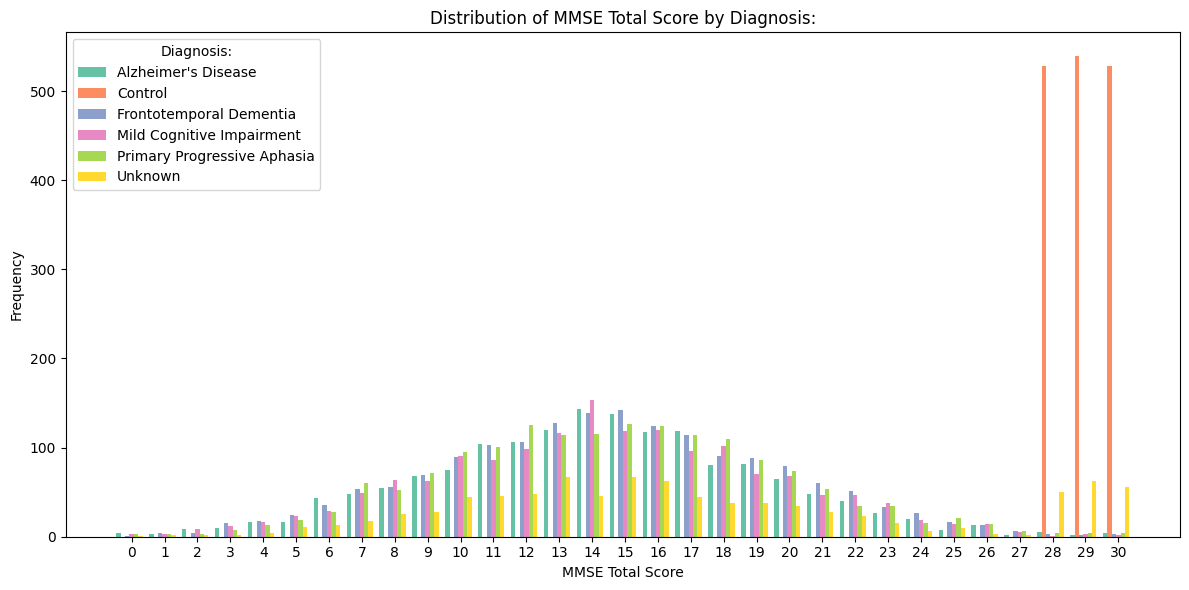

In [ ]:
# Plot the MMSE scores by Diagnoses
plot_continuous_variable_by_group(df, metadata, continuous_var='mmse_tot', group_var='diagnosis')

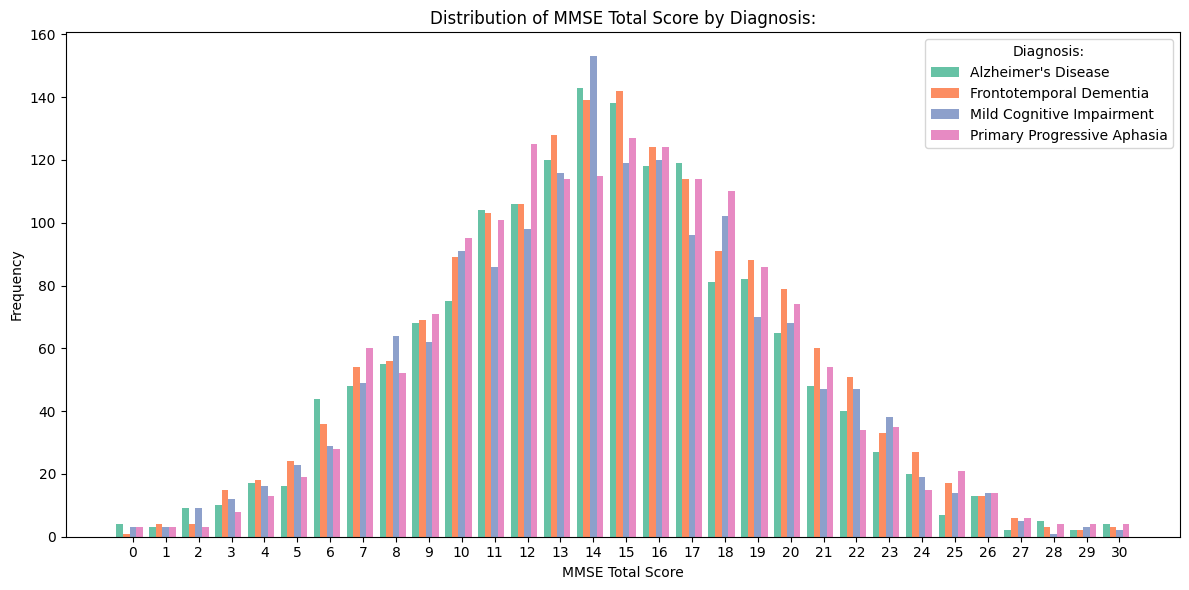

In [259]:
# Clearly the controls have higher MMSE scores (by definition) than the dementia cases, 
# so let's rerun the graph on a subset without the controls or "unknown" diagnoses for clarity:
df_trim = df_redcap[(df_redcap['diagnosis'] != '5') & (df_redcap['diagnosis'] != '')]

# Plot the MMSE scores by Diagnoses
plot_continuous_variable_by_group(df_trim, metadata, continuous_var='mmse_tot', group_var='diagnosis')

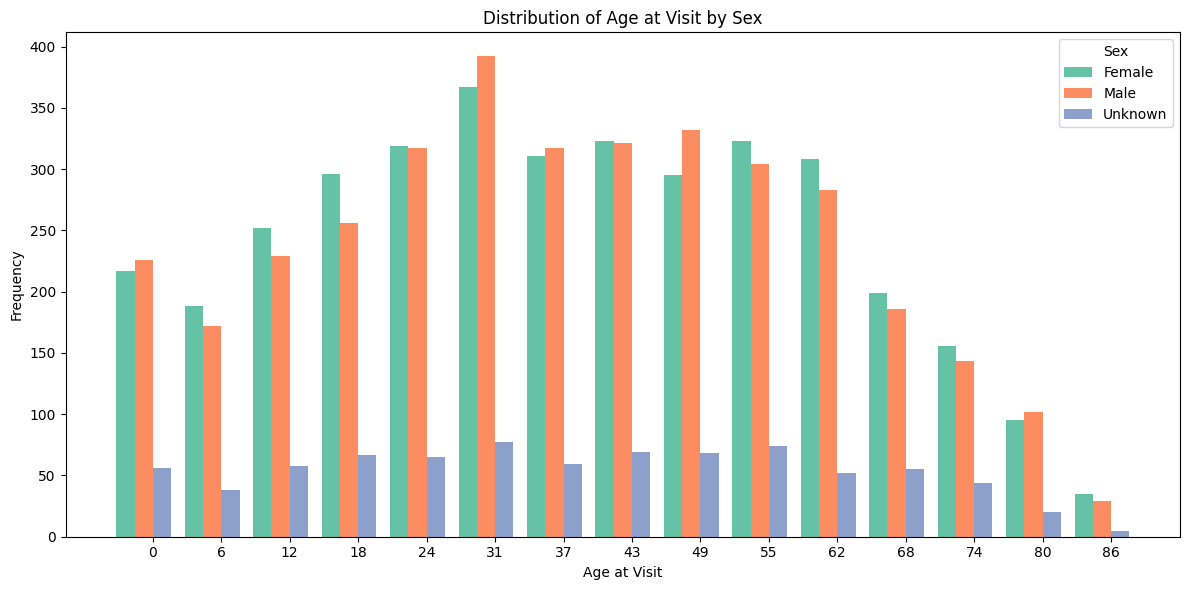

In [258]:
# Since we made a reusable function, we can also use it to plot other continuous variables by group.
# Plot Age by Sex
plot_continuous_variable_by_group(df_redcap, metadata, 'visit_age', 'sex', bins=15)